### Channel reordering of .dat and .eeg to be consistent with other ratU sessions
Original .dat file (located in google_shared_drive/diba lab data/Bapun/RatUDay1SD/Raw_data/RatU_Day1SD_256chan_64badchan_and_not_channel_odrdered.dat) which has 256 channels out of which 64 channels were bad. So new files below have only 192 channels and channels were re-ordered to reflect depthwise channel mapping:
- .eeg file channels were re-ordered using python
- .dat file channels were re-ordered using process_extractchannels

In [ ]:
from pathlib import Path
import numpy as np
import subjects

# --- Original channel order of ratU file is similar to ratN, so getting channel order from there -----
sess = subjects.sd.ratNday1[0]
chan_order = np.concatenate(sess.recinfo.channel_groups)

# ---- ratN had only one 8-shank diagbio probe, but ratU had 2 of these, with 64 channels bad in second probe ----
chan_order = np.concatenate([chan_order, chan_order[:64] + 128]).astype("int")

basefolder = Path("/data2/Clustering/RatU/RatUDay1SD/")
file = basefolder / "RatU_Day1SD_2021-07-22_07-55-46.eeg"
n_channels = 256

# ---- reordering (uncomment to run again) --------
# data = np.memmap(file, dtype="int16", mode="r").reshape(-1, n_channels)[:,chan_order]
# data.tofile(basefolder/'RatU_192chan1.eeg',format='int16')

# ---- chan_order was written to text file for using in process_extractchannels
# textfile = open(sess.filePrefix.with_suffix('.channels.txt'), "w")
# for element in list(chan_order):
#     textfile.write(str(element) + " ")
# textfile.close()

### RatU Day1 SD recording info
- No timestamps were deleted after concatenating .dat files from various folders of open-ephys

In [1]:
import numpy as np
import subjects
import matplotlib.pyplot as plt
from neuropy.utils import position_util

sess = subjects.sd.ratUday1[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46.xml 
# channels: 192
sampling rate: 30000
lfp Srate (downsampled): 1250



### Set probe configuration
- RatU_Day1SD has two probes: both 128chan-8shanks diagnostic biochips.
- 64 channels in one of the probes (implanted in left hemisphere) had no signal from 4 shanks (probably one of the intan chips was faulty). So only 192 channels were recorded, the channels in .dat file are already order according to depth.


In [ ]:
%matplotlib widget
from neuropy.core import Shank,Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- diagnostic-biochip 8 shanks -----------
for i in range(8):
    chans = channel_groups[i]
    shank =Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0,-15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

#--- dignostic biochip 4 shanks (4 shanks were bad) ----------- 
shanks = []
for i in range(8,12):

    shank = shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0, -15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp =ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.save(sess.filePrefix.with_suffix('.probegroup.npy'))
plot_probe(prbgrp)

### Writing to json format for spyking-circus 

In [ ]:
from neuropy.utils import probe_util

file = sess.filePrefix.with_suffix(".prb")
probe_util.write_spyking_circus(
    file, sess.probegroup, rmv_badchans=True, combine_shanks=True
)

# Create experimental paradigm
- pre sleep is a little shorter
- animal was lazy on re-maze

In [ ]:
sess.paradigm.to_dataframe()

In [ ]:
import pandas as pd
from neuropy.core import Epoch

datetime_data = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
durations = datetime_data.nFrames / sess.recinfo.dat_sampling_rate
epochs = pd.DataFrame(
    {
        "start": [0, 10371, 13683, 31691, 13683, 46094],
        "stop": [10370, 13682, 31691, 46093, 46093, 49832],
        "label": ["pre", "maze", "sd", "rs", "post", "re-maze"],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.save(sess.filePrefix.with_suffix(".paradigm.npy"))

In [ ]:
paradigm.to_dataframe()

In [ ]:
paradigm.durations / 3600

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [2]:
from neuropy.analyses import detect_artifact_epochs
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.core import Signal

signal = sess.eegfile.get_signal(102)
# filt_trace = signal_process.filter_sig.highpass(signal.traces,cutoff=400)
# filtered_signal = Signal(np.median(filt_trace,axis=0).reshape((1,-1)),signal.sampling_rate)
artifact_epochs = detect_artifact_epochs(signal, thresh=7)
artifact_epochs.ex
artifact_epochs.save(sess.filePrefix.with_suffix(".artifact.npy"))

/data/Clustering/sessions/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46.artifact.npy saved


<Axes: xlabel='Time (s)', ylabel='Absolute zscore'>

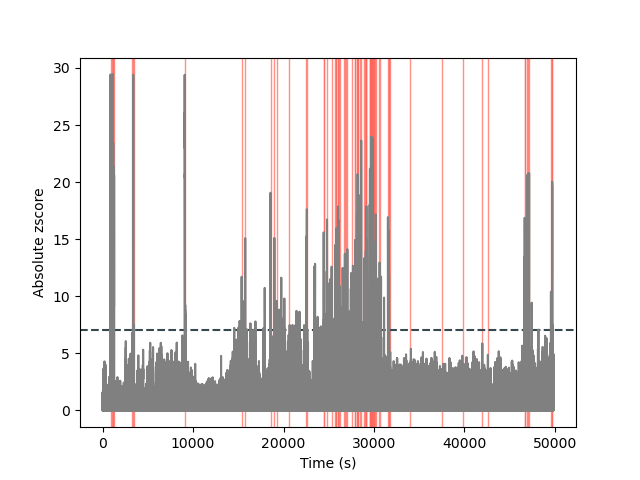

In [3]:
from neuropy import plotting

signal = sess.eegfile.get_signal([102])
# signal = Signal(filtered_signal.traces[0].reshape(1,-1),sampling_rate=1250)
plotting.plot_artifact_epochs(sess.artifact, signal)

### write artifact to neuroscope

In [ ]:
sess.recinfo.write_epochs(sess.artifact, ext=".art")

### write artifact epochs to spyking circus format

In [ ]:
from neuropy.io import SpykingCircusIO

file = sess.filePrefix.with_suffix(".dead")
SpykingCircusIO.write_epochs(file, sess.artifact)

## Sleep scoring

In [ ]:
signal.duration

In [ ]:
sig.t_stop

In [ ]:
from neuropy.utils.signal_process import filter_sig

sig = signal.time_slice(t_start=30, t_stop=40)

yf = filter_sig.bandpass(sig.traces, lf=300, hf=600, fs=1250)

In [ ]:
np.arange(0, signal.duration - 5, 3)[-2:]

In [ ]:
from neuropy.core import Signal
from neuropy.analyses import brainstates

signal = sess.eegfile.get_signal()
brainstates = brainstates.detect_brainstates_epochs(
    signal=signal, probe=sess.probegroup, window=5, overlap=2
)

In [ ]:
brainstates.filename = sess.filePrefix.with_suffix(".brainstates")
brainstates.save()

## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations

signal = sess.eegfile.get_signal()
ripple_epochs = oscillations.detect_ripple_epochs(
    signal=signal,
    probegroup=sess.probegroup,
    freq_band=(125, 250),
    ignore_epochs=sess.artifact,
)
ripple_epochs.save(sess.filePrefix.with_suffix(".ripple.npy"))

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Neurons

## Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/home/bapung/Documents/ClusteringHub/spykcirc/RatU/RatUDay1SD/RatU_Day1SD_2021-07-22_07-55-46-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id < 4] = "pyr"
neuron_type[neuron_type_id == 6] = "mua"
neuron_type[neuron_type_id == 8] = "inter"


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms, dtype="object"),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=neuron_type,
    metadata={"cluster_path": str(cluster_path)},
)

neurons.save(sess.filePrefix.with_suffix(".neurons"))

In [ ]:
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons, color="jet", add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua = sess.neurons.get_mua()
mua.save(sess.filePrefix.with_suffix(".mua.npy"))

In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix(".pbe")
pbe.save()

# Position
- concatenated .dat file did not have any deleted timepoints

## Import position from optitrack

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / "position"
opti_data = OptitrackIO(dirname=opti_folder, scale_factor=0.25)

In [ ]:
opti_data.datetime_starts

## Align position with .dat file

In [ ]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
t_error = [0, 0, 0, 0, 0.72, 0, 0, 0.26]  # estimated using theta/speed

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["startTime"]):
    # sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(
        t_error[i], unit="sec"
    )
    # + pd.Timedelta(sync_time,unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    print(duration.total_seconds() * tracking_sRate)
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
        # freq='16.66ms',
        closed="left",
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=tracking_sRate)
position.save(sess.filePrefix.with_suffix(".position"))

### Linearize position

In [ ]:
from neuropy.utils import position_util
from neuropy import plotting

maze = sess.paradigm["re-maze"].flatten()
maze_pos = sess.position.time_slice(maze[0], maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix(".remaze.linear"))


fig = plotting.Fig(2, 4, size=(8.5, 5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x, maze_pos.y)

ax = fig.subplot(fig.gs[0, 1:])
ax.plot(maze_pos.time, maze_pos.x, "r")
ax.plot(maze_pos.time, maze_pos.y, "g")
ax.plot(linear_pos.time, linear_pos.x, "k")

## Checking position alignment with .dat file
- Comparing theta power, speed and position to check if high theta periods are correlated with the speed of the animal

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process
maze= sess.paradigm['maze']
signal = sess.eegfile.get_signal([111],t_start=maze[0],t_stop=maze[1])
# spec = signal_process.SpectrogramBands(signal,window=1,overlap=0.8,norm_sig=True)

In [ ]:
from neuropy_viewer import time_frequency_viewer

time_frequency_viewer(signal, freq_params=(3, 120, 0.1))

In [ ]:
from neuropy.utils import signal_process
from scipy import stats

freqs = np.arange(1, 20, 0.5)
wavdec = signal_process.wavelet_decomp(
    stats.zscore(signal.traces[0]), sampfreq=1250, freqs=freqs
)

wvlt_power = wavdec.colgin2009()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.imshow(wvlt_power,aspect='auto',cmap='jet',vmax=80000,extent=[signal.t_start,signal.t_stop,wavdec.freqs[0],wavdec.freqs[-1]],origin='lower')
plt.plot(pos_t,speed/10,'w')

In [ ]:
indx = np.where((wavdec.freqs >= 8) & (wavdec.freqs <= 16))[0]
theta_wvlt_power = np.median(wvlt_power[indx, :], axis=0)

In [ ]:
%matplotlib widget
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

position = sess.position.time_slice(maze[0],maze[1])
rpls = sess.ripple.time_slice(maze[0],maze[1]).starts
x = position.x[:-1]
y = position.y[:-1]
pos_t = position.time[:-1]
speed = gaussian_filter1d( position.speed,sigma =20)
theta = np.interp(pos_t,spec.time,spec.theta)
theta = gaussian_filter1d(theta,sigma=20)


plt.plot(pos_t,theta*100,'r')
# plt.plot(sess.position.time,sess.position.y)
plt.plot(signal.time,theta_wvlt_power/4000,'r')
plt.plot(rpls,100*np.ones_like(rpls),'*')
plt.plot(pos_t,speed,'g')
plt.plot(pos_t,x,'gray')
plt.plot(pos_t,y,'gray')
# plt.plot(pos_t,y,'k')
# plt.plot(sess.position.time[1:],np.diff(sess.position.x)*100)
# plt.xlim([1500,1600])
plt.ylim([-400,400])

In [ ]:
position.filename = sess.filePrefix.with_suffix(".maze.linear")
position.t_start = position.t_start + 6
position.save()

In [ ]:
sess.paradigm["maze"] / 60

In [ ]:
%matplotlib widget
import scipy.signal as sg

xcorr = sg.correlate(theta,speed,mode='same')
lags= sg.correlation_lags(len(pos_t),len(pos_t),mode='same')

plt.plot(lags/position.sampling_rate,xcorr)
# plt.xlim([-20,20])




In [ ]:
%matplotlib widget
import numpy as np

x = np.array([1,2,3,7,8,9,10,15,16,17,18])
y = np.array([6,7,8,9,10,11,12])
z = np.array([2,3,2,5,6,3,4])
plt.plot(x,np.ones_like(x),'.')
plt.plot(y,2*np.ones_like(y),'.')

In [ ]:
np.interp(x, y, z)

## Run direction

In [ ]:
%matplotlib widget
from neuropy.utils import position_util
from neuropy.plotting import plot_epochs
from scipy.ndimage import gaussian_filter1d

run = position_util.run_direction(sess.lin_maze)
run.filename = sess.filePrefix.with_suffix('.running')
run.save()
_,ax = plt.subplots()
ax.plot(sess.lin_maze.time,sess.lin_maze.x)
# ax.plot(sess.lin_maze.time,gaussian_filter1d(sess.lin_maze.x,sigma=50))
plot_epochs(ax=ax,epochs=run,colors={'forward':'r','backward':'k'},alpha=0.2)


## Licking TTL epochs

In [ ]:
from neuropy.io import openephysio

ttl_folder = "/data/Clustering/sessions/RatU/RatUDay2NSD/TTL_1"
ttl = openephysio.load_ttl_events(ttl_folder, sync_info=False)
print(ttl)

In [ ]:
file = "/data/Clustering/sessions/RatU/RatUDay2NSD/timestamps.npy"
data = np.load(file)
data[0] / 30000

In [ ]:
data[0]

In [ ]:
b = (ttl["timestamps"] - 985075968) / 30000

In [ ]:
sess.eegfile.sampling_rate

In [ ]:
print(sess.eegfile)

In [ ]:
%matplotlib widget
from neuropy.plotting import plot_epochs

_,ax = plt.subplots()
ax.plot(sess.position.time,sess.position.x)
# plot_epochs(ax=ax,epochs= sess.paradigm)

for val in b:
    ax.axvline(val+45321,color='k')

# ax.set_xlim(sess.paradigm['maze'])
